# Animating Data Science
*Kantaro's Side Job*

#### By Christine Jean and Yvonne Luk

## Introduction
Long before The Internet, there was masses of uncoded information. Now, there's still plenty of uncoded information out IRL and online, but there's also some carefully coded datasets that we can utilize to make connections that we would have never imagined with we were just qualitatively evaluating data. 

If you are looking for some hardcore data scraping, this is not the tutorial for you; the dataset provided has fairly 'nice' and not noisy data. Instead, we will show you how to use and process anime and user rating information of anime to visualize, classify, and try to make recommendations by using machine learning. <br>

The <a href="https://www.kaggle.com/CooperUnion/anime-recommendations-database/">dataset</a> we will be using contains information on animes and user ratings from <a href="https://myanimelist.net/">MyAnimeList.net</a> (MAL), which is a site that allows users to keep a list of animes they're watching or have watched, as well as rate them.

## Before We Start
Below are the libraries needed to do everything in this tutorial. You will also need Python 3.<br>

For documentation on each library, refer to <b>[Resources](#Resources)</b>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree

## I. Data Collection

First, we download the data from https://www.kaggle.com/CooperUnion/anime-recommendations-database/. Our data consists of two comma-separated files: <b>anime.csv</b> and <b>rating.csv</b>. We will be using both files eventually, but we will first be focusing on loading and tidying the data from the <b>anime.csv</b> file. <br><br>
We read the csv file into a Pandas <b>DataFrame</b> called `animetable`. This is a two dimensional data structure with rows and columns (essentially a table). We then check the dimensions and preview the first few rows of the DataFrame to see what our data looks like and to ensure it was read correctly from the file. 

<b>General Tips: </b><br>
* use `df.shape` to get the DataFrame's dimensions
* use `df.head()` to preview the first 5 elements of the DataFrame
* use the `df.sampling(17)` function to get 17 randomly selected rows of the Dataframe

In [2]:
animetable = pd.read_csv('anime.csv')

print(animetable.shape)
animetable.head()

(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


By looking at the DataFrame's <b>shape</b>, we can see that there are 12,294 animes in this dataset, and we have 7 attributes for each anime: <b>id</b>, <b>name</b>, <b>genre</b>, <b>type</b>, <b>episodes</b>, <b>rating</b>, and <b>members</b>. For those unfamiliar with MyAnimeList, we have detailed what is in each column below. For those who are familiar, skip to <b>[Data Tidying](#Data-Tidying)</b>. <br>

<b><u>Attributes:</b></u>
- <b>anime_id</b>, <b>name</b>, <b>genre</b>, <b>episodes</b>: these should be pretty self explanatory - the unique ID associated with the anime given by MyAnimeList, the name of the anime, the genre(s) that the anime is in, and the number of episodes - the anime has 1 episode if it's a movie
- <b>type</b>: TV, Movie, <a href="https://www.animenewsnetwork.com/encyclopedia/lexicon.php?id=35">Original Video Animation (OVA)</a>, <a href="https://www.animenewsnetwork.com/encyclopedia/lexicon.php?id=37">Original Net Animation (ONA)</a>, Special, or Music<br>    - alternatively, check out <a href="http://www.japanesewithanime.com/2017/03/ova-ona-meaning.html">this</a> and <a href="https://aminoapps.com/c/anime/page/blog/defining-ova-ona-special-episodes-and-movies/bEto_u8PomgzmRaW7MLjQxz5LoZ6VP">this</a>
- <b>rating</b>: the average rating given by those who have rated the anime, on a scale from 1 to 10
- <b>members</b>: the number of users who have added the anime to their anime list

## II. Data Tidying

A good place to start with cleaning up our data is to check for <b>null values</b> and figure out how to deal with them. It's not ideal to leave null values in because it's not clear what a null value means compared to other values when doing any kind of analysis or visualization. Consider this: maybe a null anime name means that the mechanism used to preprocess this data was not able to read the name or the next hot anime is actually called 'Null.' Ok, granted the later is a fairly ridiculous example, but it would be within the realm of possibility.

Click <a href="http://www.residentmar.io/2016/06/12/null-and-missing-data-python.html">here</a> for another tutorial related to processing null values.

First, we see where the null values are by counting the number of nulls we have in each attribute.

In [3]:
animetable.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

We notice that <b>rating</b> has the most null values, so we use `head()` to look at some of the animes that lack ratings to see if we can figure out why they might be null and if we should remove or keep them (and if we do keep, how to deal with it).

In [4]:
print ("Number with Null Ratings: {}".format(animetable[animetable.rating.isnull()].shape[0]))

# storing this table for later ML classification
no_rating = animetable[animetable.rating.isnull()]

animetable[animetable.rating.isnull()].head()

(230, 7)


,anime_id,name,genre,type,episodes,rating,members
8968,34502,Inazma Delivery,"Action, Comedy, Sci-Fi",TV,10,NaN,32
9657,34309,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...,"Comedy, Supernatural",TV,Unknown,NaN,129
10896,34096,Gintama (2017),"Action, Comedy, Historical, Parody, Samurai, S...",TV,Unknown,NaN,13383
10897,34134,One Punch Man 2,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,Unknown,NaN,90706
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999


After a general glance through the list, everything without a rating hadn't aired when this dataset was created. Because we will later use the ratings for ML analysis, we are throwing out these rows, and saying that we are only analyzing anime from pre-2017. Ok, these don't have the years on them, but we are weebs so we can tell. Trust us.<br><br>
We use `dropna()` to remove these rows, and check for more null values.

In [5]:
animetable = animetable.dropna(subset=['rating'])
animetable.isnull().sum()

We notice that some of the null values in other attributes were for the same animes as the ones without ratings. However, there are still some animes with null values, in <b>genre</b>, so we look at those.

In [7]:
print ("Number without genre: {}".format(animetable[animetable.genre.isnull()].shape[0]))
animetable[animetable.genre.isnull()].head()

(47, 7)


,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607


We decide to throw out the instances without genres as well. There are only a few, with generally low interest, and we still have a lot of data to consider (12,000+ other animes).

In [8]:
animetable = animetable.dropna(subset=['genre'])

We also notice that some animes have an <b>'unknown' number of episodes</b>. We check which ones do and how many there are.

In [9]:
print("Number with 'Unknown' episodes: {}".format(animetable[animetable.episodes == 'Unknown'].shape[0]))
animetable[animetable.episodes == 'Unknown'].head()

(187, 7)


,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,Unknown,7.94,533578
991,966,Crayon Shin-chan,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",TV,Unknown,7.73,26267
1021,33157,Tanaka-kun wa Itsumo Kedaruge Specials,"Comedy, School, Slice of Life",Special,Unknown,7.72,5400


After glancing through this list, we treat all unknown episode values by replacing them with 1. In this case, we want to keep the corresponding data, but also be able to treat the episodes as numerical values.

Now, you might think, is it ok to just replace something with an arbitrary value? 1 is not completely arbitrary; to be on this list, an anime must have at least one entity. For the sake of keeping the some of the popular animes with unknown episodes, we give it such value. However, later as we will see in ML, the number of episodes gets omitted for classification because of the 'arbitrary-ness' of assigning 'Unknown' to 1.

As a general note, in data science, there's not always a right or wrong decision, as long as you've justified why you've chosen an approach. [Here is a short read on the difficulties of counting](http://daynebatten.com/2016/06/counting-hard-data-science/); though not completely the same statistical use, we are trying to figure out which animes to count or not count in our analysis.

In [10]:
animetable.episodes = animetable.episodes.replace(['Unknown'], 1)

After dealing with unknown and null values, we convert our <b>quantitative values</b> in our DataFrame from <b>strings</b> to <b>numbers</b> so we can do some math!

In [11]:
animetable.episodes = animetable.episodes.astype(int)
animetable.rating = animetable.rating.astype(float)
animetable.members = animetable.members.astype(int)
animetable.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Having dealt with the <b>anime.csv</b> file, we now turn to the <b>rating.csv</b> file, reading the file in and checking it. 

In [12]:
ratingtable = pd.read_csv('rating.csv')
print("Number of ratings: {}".format(ratingtable.shape[0]))
print("Number of raters: {}".format(len(ratingtable.user_id.unique())))
ratingtable.head()

(7813737, 3)
[    1     2     3 ..., 73514 73515 73516]


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [13]:
ratingtable.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

The DataFrame for ratings seems fine. This DataFrame contains the ratings given by 73,516 users to animes on their list - their rating is given on a scale of 1 to 10, with -1 representing a rating not given.


## Data Visualization
Here are some of the things we want to visually show:
- What is the most popular genre of anime?
- Do animes with more genres do better in terms of rating?
- Do animes with more genres do better in terms of popularity (measured by community size)?

First, we want to see <b>how many animes are in each genre</b>. As is, our <b>genre</b> column is a string representing all the genres the anime is in. If we want to do visualization and analysis with genres later, we need to tidy it, which we do by making each genre into an attribute, which then has a boolean value representing whether the anime is in that genre or not. We also create a column called <b>genreCount</b> to count the number of genres each anime has (to be used later).

In [14]:
animetable.genre = animetable.genre.apply(lambda x: x.split(', '))
animetable['genreCount'] = animetable.genre.apply(lambda x: len(x))

In [15]:
# create unique list of all possible genres
genre_list = list(itertools.chain.from_iterable(animetable.genre.values.flatten()))
genre = np.unique(genre_list)
print("There are {} genres".format(len(genre)))
genre

43


array(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts',
       'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen',
       'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life',
       'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller',
       'Vampire', 'Yaoi', 'Yuri'], 
      dtype='<U13')

In [16]:
# create attributes for each genre with 1/0 values representing whether the anime is a certain genre
for category in genre: # loops through each category type
    # the lambda function basically figures out if a genre is in the list and if it is, assigns a 1, otherwise a 0
    no_rating[category] = no_rating.genre.apply(lambda x: int(category in x))
    animetable[category] = animetable.genre.apply(lambda x: int(category in x))

animetable = animetable.drop(['genre'], axis = 1)
animetable.head()

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,7,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51,9.25,114262,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24,9.17,673572,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0


We make a DataFrame with counts for each genre to see how many animes are in each genre.

In [17]:
genre_count = []

for category in genre: 
    genre_count.append(genre_list.count(category))
    
dict = {'genre': genre, 'count':genre_count}
genre_df = pd.DataFrame(dict) 

In [18]:
animetable.head()

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,7,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51,9.25,114262,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24,9.17,673572,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
genre_df.sort_values(by = "count", ascending = False)

,count,genre
3,4575,Comedy
0,2768,Action
1,2316,Adventure
8,2242,Fantasy
28,2036,Sci-Fi
6,1977,Drama
32,1684,Shounen
15,1598,Kids
25,1437,Romance
34,1204,Slice of Life


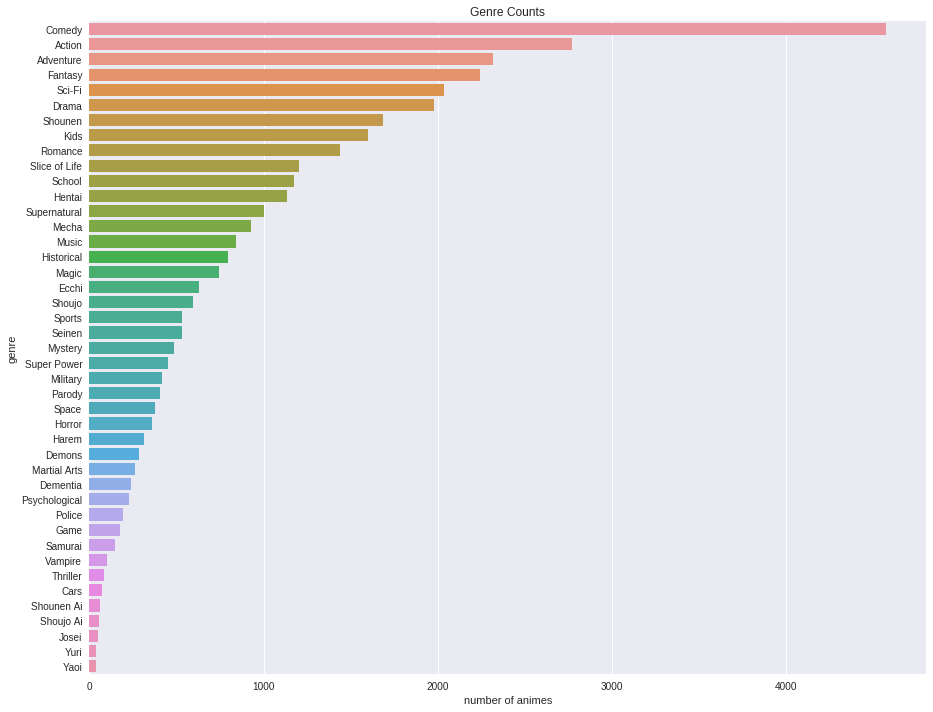

In [20]:
# lets graph this!
fig, ax = plt.subplots(figsize=(15, 12))
result = genre_df.groupby(["genre"])['count'].aggregate(np.median).reset_index().sort_values('count', ascending = False)
sns.barplot(x="count", y="genre", data=genre_df, order = result['genre'], ax = ax).set_title("Genre Counts")
ax.set(xlabel="number of animes")
plt.show()

From this, we can see <b>Comedy</b> is the genre with the most animes in it by a large margin, followed by <b>Action</b>, <b>Adventure</b>, and <b>Fantasy</b>, which are much closer together in count. <br><br>

Next, we want to count the <b>number of users</b> from the ratings dataset who have the anime on their list and <b>rated or didn't rate the anime</b>, so for each anime in our anime DataFrame, we count how many users gave that anime a -1 rating (didn't rate) or an actual rating. We do this by creating two new columns, <b>unrated</b> and <b>rated</b> and <b>applying a function</b> to every row in the anime dataframe. <br><br>
Then, we create a DataFrame with the number of ratings given/not given in each genre by summing the <b>unrated</b> and <b>rated</b> for every anime in each genre.

In [21]:
#running this cell will make you cry for 30 minutes

animetable['unrated'] = animetable.anime_id.apply(lambda x: ratingtable[
    (ratingtable['anime_id'] == x) & (ratingtable['rating']==-1)].shape[0])
animetable['rated'] = animetable.anime_id.apply(lambda x: ratingtable[
    (ratingtable['anime_id'] == x) & (ratingtable['rating']!=-1)].shape[0])
animetable.head()

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,unrated,rated
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,4,0,0,0,...,0,0,0,1,0,0,0,0,238,1961
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,7,1,1,0,...,0,0,0,0,0,0,0,0,3080,21494
2,28977,Gintama°,TV,51,9.25,114262,7,1,0,0,...,0,0,0,0,0,0,0,0,198,1188
3,9253,Steins;Gate,TV,24,9.17,673572,2,0,0,0,...,0,0,0,0,1,0,0,0,2132,17151
4,9969,Gintama&#039;,TV,51,9.16,151266,7,1,0,0,...,0,0,0,0,0,0,0,0,558,3115


In [22]:
# creating two Pandas Series to keep count
genreRated = pd.Series()
genreUnrated = pd.Series()
for g in genre:
    genreRated[g] = animetable[animetable[g]==1].rated.sum()
    genreUnrated[g] = animetable[animetable[g]==1].unrated.sum()

In [23]:
# combining this information into a DataFrame
genreTotal = genreRated + genreUnrated

ratingGenres = pd.DataFrame({'genre': genre, 'unrated':genreUnrated,'rated':genreRated,'total':genreTotal})
ratingGenres.reset_index(drop = True, inplace=True)
ratingGenres.sort_values(by = "total", ascending = False)

,genre,rated,total,unrated
3,Comedy,3150030,3908785,758755
0,Action,2663843,3263393,599550
25,Romance,2031673,2487902,456229
6,Drama,1727683,2101320,373637
8,Fantasy,1629076,2021336,392260
38,Supernatural,1612457,1964112,351655
27,School,1540798,1884897,344099
32,Shounen,1514011,1882226,368215
1,Adventure,1365199,1695965,330766
28,Sci-Fi,1319449,1613124,293675


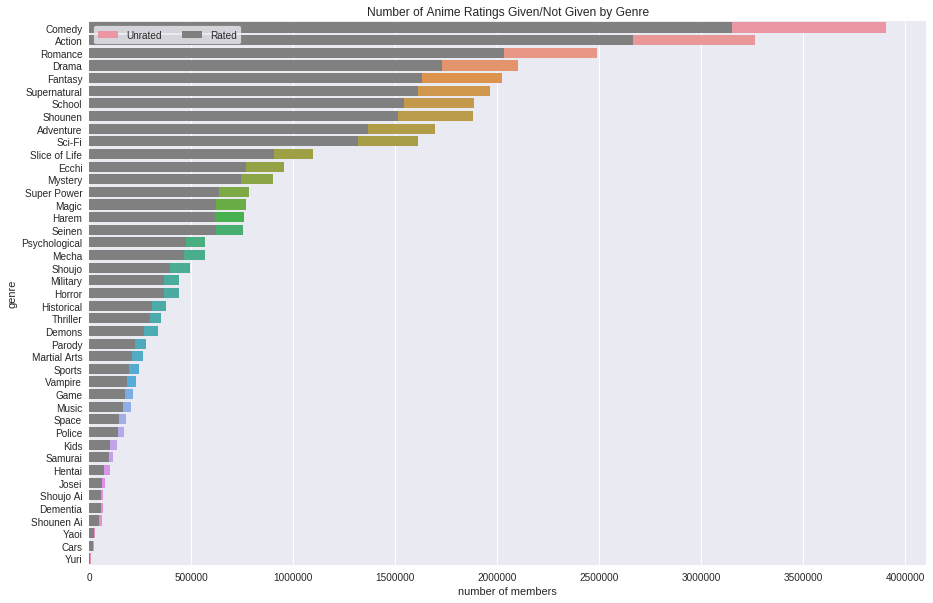

In [24]:
# graphing number of ratings given/not given by genre

f, ax = plt.subplots(figsize=(15,10))
result = ratingGenres.groupby(["genre"])['total'].aggregate(np.median).reset_index().sort_values('total', ascending = False)
# using 'Total' to stack unrated and rated - just the length of the colored part is 'Unrated'
sns.barplot(x="total", y="genre", data=ratingGenres, order = result['genre'], label="Unrated") 
sns.barplot(x="rated", y="genre", data=ratingGenres, order = result['genre'], color = 'gray', label="Rated")

ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set(ylabel="genre",
       xlabel="number of members",
       title = "Number of Anime Ratings Given/Not Given by Genre")

plt.show()

From this we can confirm that there are more ratings given than not given for each genre, which makes sense because the two sets of data were intended to be used in helping making recommendations and would make use of rating data. We can also see that the number of members who gave ratings for animes in each genre is proportional to the number of memebers with the anime on their list in each genre - there isn't an underrepresentation of one genre or an overrepresentation of another genre.

Next we want to show the <b>number of members vs ratings given for each anime, grouped by type</b>.

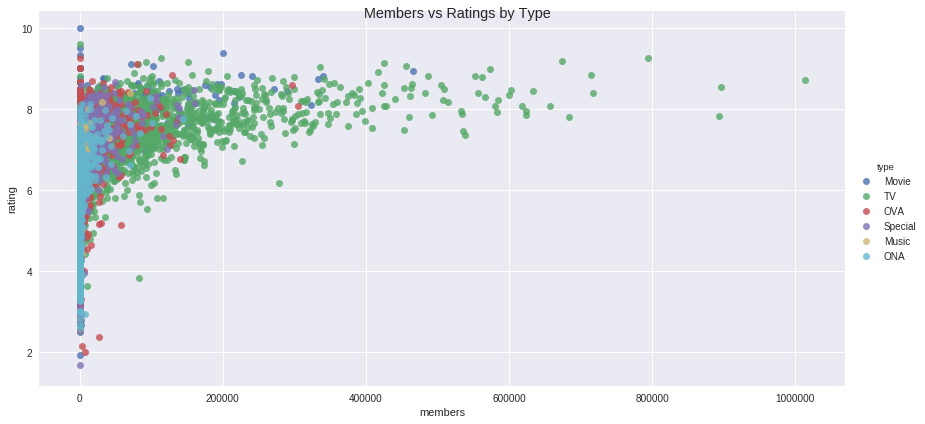

In [25]:
g = sns.lmplot(y = "rating", x = "members", data=animetable, hue="type", size = 6, aspect = 2, fit_reg=False)
g.fig.suptitle("Members vs Ratings by Type")

Generally, we see the same rating shape for each type, the main difference is in the amount of members, with <b>TV</b> type having the most. This makes sense because the TV animes are the ones that tend to have more content so thus more followers.

We also want to see <b>how many genres animes typically have</b>, so we plot the number of animes vs number of genres it's in.

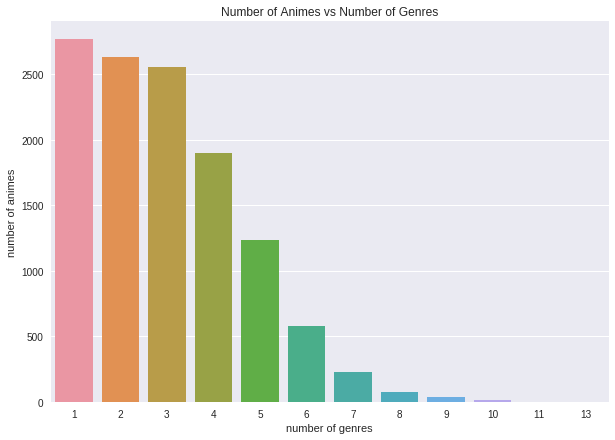

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x="genreCount", data=animetable, ax = ax)
ax.set(xlabel="number of genres",
       ylabel="number of animes",
       title="Number of Animes vs Number of Genres")

From this, we can see most animes have 1, 2, or 3 genres, with there being fewer and fewer animes as number of genres increases.

Now, we want to see the how <b>ratings</b> fare <b>vs number of genre, grouped by type of anime</b>.

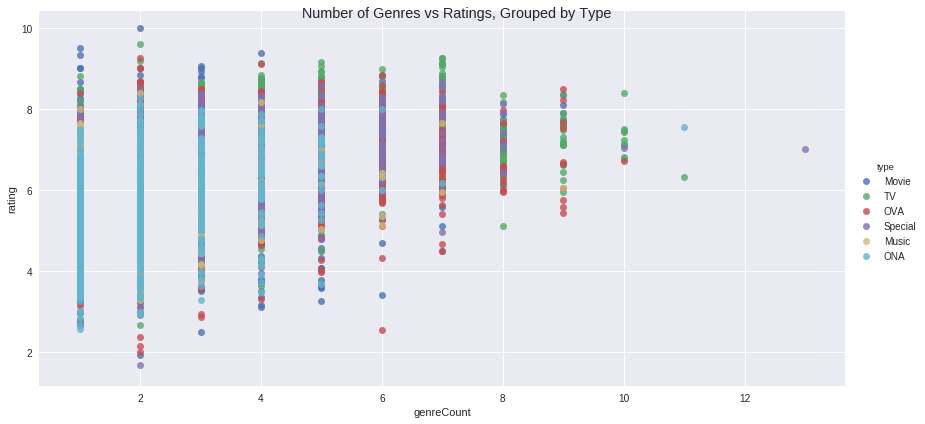

In [27]:
g = sns.lmplot(x = "genreCount", y = "rating", data=animetable, hue='type', size = 6, aspect = 2, fit_reg=False)
g.fig.suptitle("Number of Genres vs Ratings, Grouped by Type")

<div class="alert alert-block alert-danger">CONCLUSIONS TO BE DRAWN</div>

And finally, we see if there's a relation between the number of members and the genre counts, grouped by type.

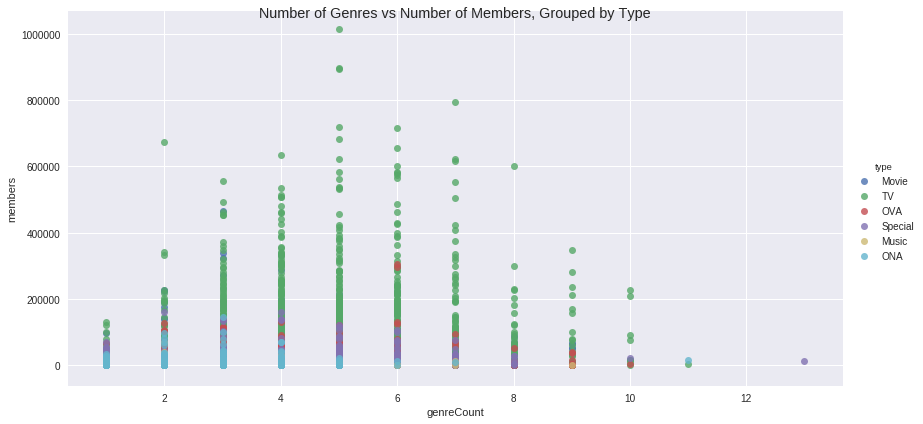

In [28]:
g = sns.lmplot(x = "genreCount", y = "members", data=animetable, hue='type', size = 6, aspect = 2, fit_reg=False)
g.fig.suptitle("Number of Genres vs Number of Members, Grouped by Type")

From the plot above, we can tell that the animes with the most members are the <b>TV</b> ones, and the most popular animes seem to have around 3-7 genres.

## Machine Learning


We first want to see if we can try <b>classifying by popularity</b>. To do this, we put animes into groups by the number of members following the anime, and plotting that.

In [29]:
# let's figure out if we can somehow classify by popularity, based on number of members
# as a general note, rating also could factor into popularity, but couldn't think of any nice way of 
# weighting such, since there are many low interest, high rating pieces as shown before
animetable['membersRange'] = animetable.members.apply(lambda a: max(0, (int(a) - (int(a) % 50000))))
animetable['membersRangeLog'] = animetable.members.apply(lambda a: int(math.log(a, 10)))

In [30]:
animetable.head()

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,unrated,rated,membersRange,membersRangeLog
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,4,0,0,0,...,0,1,0,0,0,0,238,1961,200000,5
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,7,1,1,0,...,0,0,0,0,0,0,3080,21494,750000,5
2,28977,Gintama°,TV,51,9.25,114262,7,1,0,0,...,0,0,0,0,0,0,198,1188,100000,5
3,9253,Steins;Gate,TV,24,9.17,673572,2,0,0,0,...,0,0,1,0,0,0,2132,17151,650000,5
4,9969,Gintama&#039;,TV,51,9.16,151266,7,1,0,0,...,0,0,0,0,0,0,558,3115,150000,5


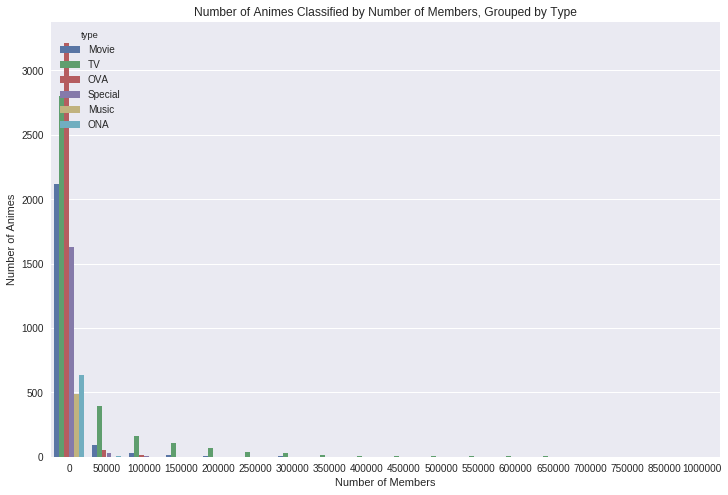

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.countplot(x="membersRange", hue = "type", data=animetable, ax= ax)
ax.set(title="Number of Animes Classified by Number of Members, Grouped by Type",
      xlabel="Number of Members",
      ylabel="Number of Animes")
#as we can see below, not v useful

As can be seen, most anime get classified into the 0 - 50,000 range, which is not very helpful. We try again, this time taking the log of the number of members instead and plotting that.

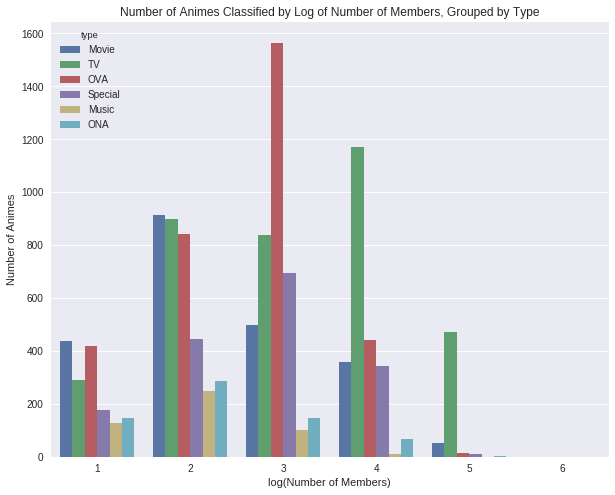

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.countplot(x="membersRangeLog", hue = "type", data=animetable, ax = ax)
ax.set(title="Number of Animes Classified by Log of Number of Members, Grouped by Type",
      xlabel="log(Number of Members)",
      ylabel="Number of Animes")

<div class="alert alert-block alert-danger">CONCLUSIONS TO BE DRAWN idk what to say and also why you're looking at the 1k, 10k</div>

In [33]:
print(animetable[animetable['membersRangeLog'] == 3].sample(10).name)
print(animetable[animetable['membersRangeLog'] == 4].sample(10).name)

5526                                    Mach GoGoGo (1997)
11363                               Saimin Ryoujoku Gakuen
2623     Precure All Stars Movie New Stage: Mirai no To...
2853                                              Roujin Z
11801                                              Mizuiro
683             Sexy Commando Gaiden: Sugoiyo!! Masaru-san
2147                          Gugure! Kokkuri-san Specials
6380                                             Hero Bank
1860     Hibike! Euphonium Movie: Kitauji Koukou Suisou...
6082                            Top wo Nerae! Kagaku Kouza
Name: name, dtype: object
1628                  Ikoku Meiro no Croisée The Animation
11566                               Aki-Sora: Yume no Naka
997                         Katekyo Hitman Reborn! Special
5086                     Akaneiro ni Somaru Saka: Hardcore
5152     Saikin, Imouto no Yousu ga Chotto Okashiinda g...
1607               Strike Witches: Operation Victory Arrow
2037                          

We arbitrarily decide that anything with more than 10,000 members will be considered "popular". We thus make a column in the DataFrame labeling the anime as being popular or not.

In [34]:
animetable['popularClass'] = animetable.membersRangeLog.apply(lambda a: int(a > 3))

In [35]:
animetable.sample(10)

,anime_id,name,type,episodes,rating,members,genreCount,Action,Adventure,Cars,...,Supernatural,Thriller,Vampire,Yaoi,Yuri,unrated,rated,membersRange,membersRangeLog,popularClass
535,9465,Break Blade 4: Sanka no Chi,Movie,1,7.99,41598,5,1,0,0,...,0,0,0,0,0,514,1942,0,4,1
3959,7329,Tottoko Hamtarou Movie 1: Ham-Ham Land Daibouken,Movie,1,6.84,1472,3,0,1,0,...,0,0,0,0,0,13,35,0,3,0
4187,3023,Esper Mami,TV,119,6.78,612,6,0,0,0,...,1,0,0,0,0,3,6,0,2,0
2756,442,Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shin...,Movie,1,7.17,120571,6,0,1,0,...,1,0,0,0,0,1949,5897,100000,5,1
11569,24273,Iinari! Saimin Kanojo,OVA,2,6.41,2867,1,0,0,0,...,0,0,0,0,0,18,37,0,3,0
2353,16742,Watashi ga Motenai no wa Dou Kangaetemo Omaera...,TV,12,7.29,257925,4,0,0,0,...,0,0,0,0,0,1399,6845,250000,5,1
3582,13281,FlashBack,Music,1,6.94,1508,1,0,0,0,...,0,0,0,0,0,13,54,0,3,0
872,24135,Nobunaga Concerto,TV,10,7.79,25167,3,0,0,0,...,0,0,0,0,0,87,518,0,4,1
8408,31978,Crayon Shin-chan Movie 24: Bakusui! Yumemi Wor...,Movie,1,7.30,320,3,0,0,0,...,0,0,0,0,0,0,1,0,2,0
1203,2174,Hokuto no Ken: Raoh Gaiden Gekitou-hen,Movie,1,7.63,4614,4,1,1,0,...,0,0,0,0,0,37,156,0,3,0


In [36]:
# lets use some classifier to figure out guess if something will be popular or not!

In [37]:
#let's see if we can predict if something will be popular or not with genre, type, and potentially episodes 
# may want to consider if we want episodes or not
#attributes = pd.concat([animetable[genre],animetable[format_type],animetable["episodes"]],axis=1)

#https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

format_type = [s for s in list(animetable) if "type_" in s]
animetable_type = pd.get_dummies(animetable, columns = ['type'])
attributes = pd.concat([animetable[genre],animetable[format_type]],axis=1)
classification = np.array(animetable['popularClass']) 	# another way of indexing a pandas df

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(attributes, classification, test_size=0.2, random_state=42)

In [38]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
print (accuracy_score(y_test, pred))

0.803244592346


In [39]:
#let's try to establish some optimal k without overfitting
accuracy_scores = []

for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k)

    # fitting the model
    knn.fit(X_train, y_train)

    # predict the response
    pred = knn.predict(X_test)

    # evaluate accuracy
    print (accuracy_score(y_test, pred))

0.779950083195
0.799500831947
0.803244592346
0.804492512479
0.810316139767
0.802828618968
0.8115640599
0.799500831947
0.808236272879
0.803244592346
0.80615640599
0.802828618968
0.806572379368
0.805324459235


In [40]:
# creating odd list of K for KNN
myList = list(range(1,15,2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation <-- why is this necessary?
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

In [41]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = myList[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 13


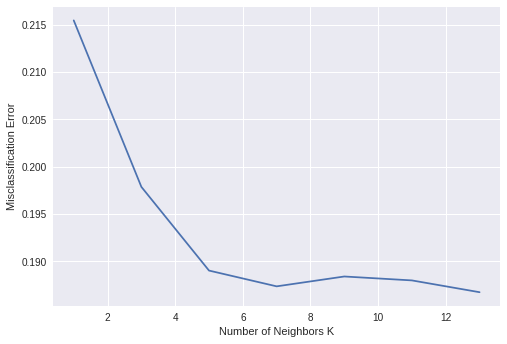

In [42]:
# plot misclassification error vs k
plt.plot(myList, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [43]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)

    # fitting the model
knn.fit(X_train, y_train)

    # predict the response
pred = knn.predict(X_test)

    # evaluate accuracy
print (accuracy_score(y_test, pred))

0.806572379368


now just for fun, what if we want to get anime recommendations?

In [44]:
#let's keep the attributes the same, but we can consider adding elements now
format_type = [s for s in list(animetable) if "type_" in s]
attributes = pd.concat([animetable[genre],animetable[format_type]],axis=1)

#attributes = pd.concat([animetable[genre],animetable[format_type],animetable[["members"]],animetable[["rating"]],
#                        animetable["episodes"]],axis=1)

#nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(attributes)
#distances, indices = nbrs.kneighbors(attributes)
#distance_total = 

In [45]:
def findAnime(name, df):
    list = []
    indices = []
    for index, row in df.iterrows():
        if (name in row['name']):
            list.append(row['name'])
            indices.append(row.name)
    return list, indices
    
animelist, indices = findAnime("Naruto", animetable)
animelist

['Boruto: Naruto the Movie',
 'Naruto: Shippuuden',
 'The Last: Naruto the Movie',
 'Naruto: Shippuuden Movie 6 - Road to Ninja',
 'Naruto',
 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi',
 'Naruto: Shippuuden Movie 5 - Blood Prison',
 'Naruto x UT',
 'Naruto: Shippuuden Movie 4 - The Lost Tower',
 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono',
 'Naruto: Shippuuden Movie 1',
 'Naruto: Shippuuden Movie 2 - Kizuna',
 'Naruto Shippuuden: Shippuu! &quot;Konoha Gakuen&quot; Den',
 'Naruto: Honoo no Chuunin Shiken! Naruto vs. Konohamaru!!',
 'Naruto SD: Rock Lee no Seishun Full-Power Ninden',
 'Naruto Shippuuden: Sunny Side Battle',
 'Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!',
 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!',
 'Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!',
 'Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! Special: Konoha Annual Sports Festival',
 'Naruto Movie 3: D

In [46]:
def findSimilar(index, df, attributes, neighbors = 2):
    list = []
    tree = BallTree(attributes, leaf_size=2)              
    dist, ind = tree.query([attributes.iloc[index]], k = neighbors)
    for i in ind.flatten():
        list.append(animetable.iloc[i]['name'])
    return list

findSimilar(indices[1], animetable, attributes, 10) # well it makes sense they are all naruto lmao

['Naruto x UT',
 'Naruto: Shippuuden Movie 4 - The Lost Tower',
 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!',
 'Naruto Shippuuden: Sunny Side Battle',
 'Naruto: Shippuuden',
 'Boruto: Naruto the Movie',
 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi',
 'Naruto',
 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono',
 'Battle Spirits: Ryuuko no Ken']